In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from utils.angle_data import get_data, AngleData, SingleRun
from utils.style import make_style
import mplhep as hep
make_style()

from jacobi import propagate
from iminuit import Minuit
from iminuit.pdg_format import pdg_format

from iminuit.cost import LeastSquares
import glob


In [2]:
plt.rcParams['figure.dpi'] = 150

# Gold-Film (Au) sample fitting

The complete analysis for the gold layer is made just from considering the 1-layer fresnel approximation, omimtting the possibility of any two or three layer system. 

In [3]:
p_Au_ADL_ = get_data(sorted(glob.glob('../data/dataAu_1/**')), 23)
s_Au_ADL_ = get_data(sorted(glob.glob('../data/dataAu_0/**')), 23)

s_Au = SingleRun(s_Au_ADL_, s_Au_ADL_[-1])
p_Au = SingleRun(p_Au_ADL_, p_Au_ADL_[-1])

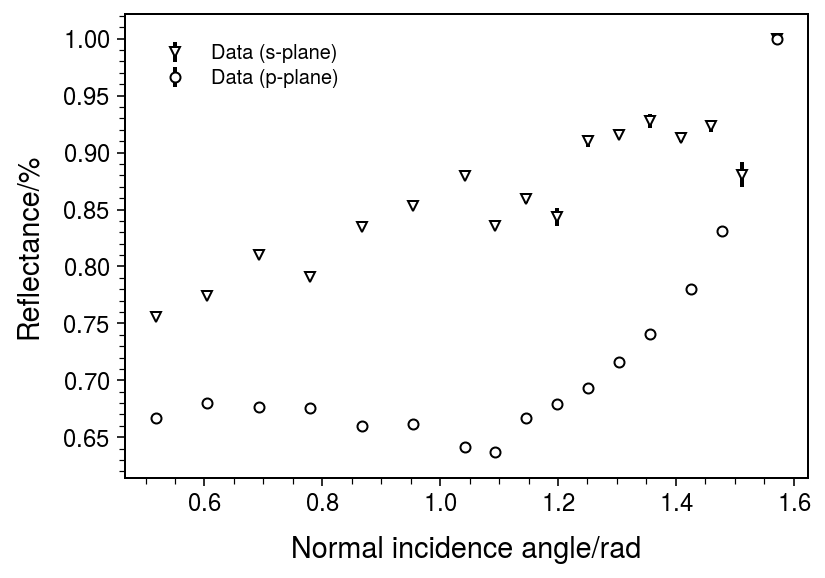

In [4]:
s_Au.plot(marker='v')
p_Au.plot(marker='o')
plt.legend()

In [5]:
def r_p(theta, ni, nt):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return (
        (nt * np.cos(theta) - ni * cos_transmitted) / (ni * cos_transmitted + nt * np.cos(theta))
    )

def r_s(theta, ni, nt):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return (
        (ni * np.cos(theta) - nt * cos_transmitted) / (ni * np.cos(theta) + nt * cos_transmitted)
    )

def Au_Rs(theta, n1, n2, phase):
    rs = r_s(theta-phase, n1, n2)
    return np.abs( rs * np.conj(rs) )

def Au_Rp(theta, n1, n2, phase):
    rp = r_p(theta-phase, n1, n2)
    return np.abs( rp * np.conj(rp) )

## CommRR$\chi^2$ model, using LS from `iminuit`

In [6]:
n_Air  = 1.00027821
n_Au   = 0.54463
k_Au   = 2.1406

parameters = [n_Air, 0, n_Au, k_Au, 0]

modelRs = lambda x, p: Au_Rs(x, p[0]+p[1]*1j, p[2]+p[3]*1j, p[4])
modelRp = lambda x, p: Au_Rp(x, p[0]+p[1]*1j, p[2]+p[3]*1j, p[4])

CommRRChi2 = (
    LeastSquares(s_Au.angles, s_Au.reflectance, s_Au.reflectance_std, model=modelRs) + 
    LeastSquares(p_Au.angles, p_Au.reflectance, p_Au.reflectance_std, model=modelRp)
)

CommRRC2MM = Minuit(CommRRChi2, parameters)

# Fixing Air values
CommRRC2MM.fixed[0] = True
CommRRC2MM.fixed[1] = True

CommRRC2MM.limits[2] = (0,2)
CommRRC2MM.limits[3] = (0,3)

CommRRC2MM.migrad()
CommRRC2MM.hesse()
CommRRC2MM.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2116 (chi2/ndof = 70.5)    │              Nfcn = 138              │
│ EDM = 3.2e-13 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │  0.3233   │  0.0029   │            │            │    0    │    2    │       │
│ 3 │ x3   │   1.750   │   0.011   │            │            │    0    │    3    │       │
│ 4 │ x4   │  0.0200   │  0.0015   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0   8.5e-06  3.24e-05 -2.48e-06 │
│ x3 │         0         0  3.24e-05   0.00013  -8.5e-06 │
│ x4 │         0         0 -2.48e-06  -8.5e-06  2.32e-06 │
└────┴───────────────────────────────────────────────────┘

In [7]:
def CLs_plot(m: Minuit, model: callable, cx, parameters, color):
    y, ycov = propagate(lambda p: model(cx, p), m.values, m.covariance)
    plt.plot(cx,y,color=color)
    # plt.plot(cx, model(cx, parameters), 'k:')
    yerr_prop = np.diag(ycov) ** 0.5
    plt.fill_between(cx, y - yerr_prop, y + yerr_prop, facecolor=color, alpha=0.5)

In [8]:

angles = np.linspace(np.pi/7, np.pi/2, 500)

nAir, kAir, nAu, kAu, phi = CommRRC2MM.values
nAir_std, kAir_std, nAu_std, kAu_std, phi_std = CommRRC2MM.errors

res_RS_TH = Au_Rs(angles, n_Air, n_Au+k_Au*1j,0) - Au_Rs(angles, nAir, nAu+kAu*1j,phi)
res_RS_DP = s_Au.reflectance - Au_Rs(s_Au.angles, nAir, nAu+kAu*1j, phi)

res_RP_TH = Au_Rp(angles, n_Air, n_Au+k_Au*1j,0) - Au_Rp(angles, nAir, nAu+kAu*1j,phi)
res_RP_DP = p_Au.reflectance - Au_Rp(p_Au.angles, nAir, nAu+kAu*1j, phi)


In [9]:

import hist

res_RSH = hist.Hist(hist.axis.Regular(5, res_RS_DP.min(), res_RS_DP.max()))
res_RSH.fill(res_RS_DP)


Hist(Regular(5, -0.0983623, 0.0167641, label='Axis 0'), storage=Double()) # Sum: 16.0 (17.0 with flow)

In [10]:
res_RPH = hist.Hist(hist.axis.Regular(5, res_RP_DP.min(), res_RP_DP.max()))
res_RPH.fill(res_RP_DP)

Hist(Regular(5, -0.0311172, 0.027577, label='Axis 0'), storage=Double()) # Sum: 15.0 (16.0 with flow)

In [11]:
def sigma_from_residuals(residuals):
    return np.sqrt(np.sum(residuals**2)/(len(residuals) - 2))

error_RS_scale = sigma_from_residuals(res_RS_DP)
error_RP_scale = sigma_from_residuals(res_RP_DP)

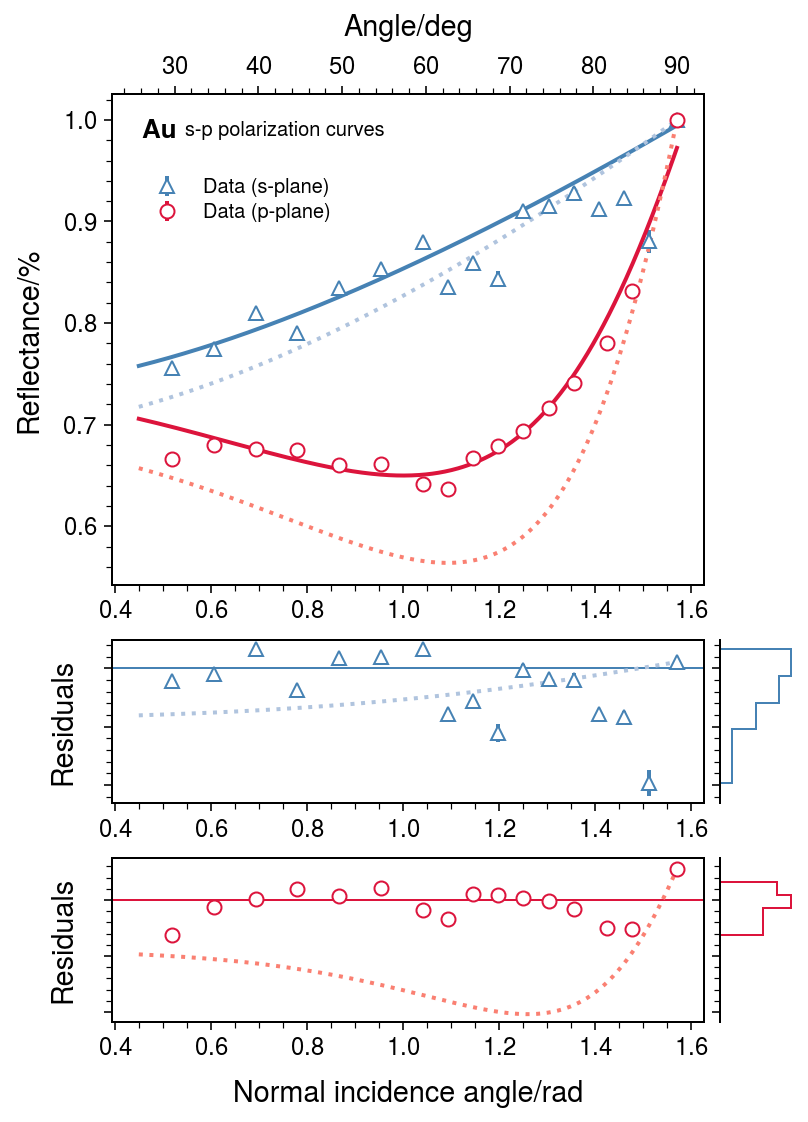

In [12]:
s_color = 'steelblue'
p_color = 'crimson'
markersize=7

fig = plt.figure(figsize=(6,8))
grid = fig.add_gridspec(3, 2, height_ratios=[3,1,1], width_ratios=[8,1], wspace=0.05)

plt.subplot(grid[0,0])

s_Au.plot(marker='^', color=s_color, markersize=markersize)
p_Au.plot(color=p_color, markersize=markersize)

hep.label.exp_text('Au ', 's-p polarization curves', loc=1)

CLs_plot(CommRRC2MM, modelRp, angles, parameters, p_color)
CLs_plot(CommRRC2MM, modelRs, angles, parameters, s_color)

plt.plot(angles, Au_Rs(angles, n_Air, n_Au+k_Au*1j,0), color='lightsteelblue', ls=':')
plt.plot(angles, Au_Rp(angles, n_Air, n_Au+k_Au*1j,0), color='salmon', ls=':')
plt.xlabel('')

ax = plt.gca().secondary_xaxis('top', functions=(np.rad2deg, np.deg2rad))
ax.set_xlabel('Angle/deg')
plt.legend(loc=(0.025, 0.7))

ax1 = fig.add_subplot(grid[1,0], sharex=plt.gca())

ax1.axhline(0, color=s_color, lw=1)
ax1.plot(angles, res_RS_TH, color='lightsteelblue', ls=':')
ax1.errorbar(s_Au.angles, res_RS_DP, s_Au.reflectance_std, color=s_color, fmt='^', markersize=markersize, mfc='w')
ax1.set_ylabel('Residuals')

ax3 = fig.add_subplot(grid[1,1], sharey=ax1)
hep.histplot(res_RSH, yerr=False, ax=ax3, color=s_color, orientation='horizontal')
ax3.set_yticklabels([])
ax3.set_xticks([])
ax3.set_xlabel('')

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax2 = fig.add_subplot(grid[2,0], sharex=ax1)

ax2.axhline(0, color=p_color, lw=1)
ax2.plot(angles, res_RP_TH, color='salmon', ls=':')
ax2.errorbar(p_Au.angles, res_RP_DP, p_Au.reflectance_std, color=p_color, fmt='o', markersize=markersize, mfc='w')

ax2.set_ylabel('Residuals')
ax2.set_xlabel('Normal incidence angle/rad')

ax4 = fig.add_subplot(grid[2,1], sharey=ax2)
hep.histplot(res_RPH, yerr=False, ax=ax4, color=p_color, orientation='horizontal')
ax4.set_yticklabels([])
ax4.set_xticks([])
ax4.set_xlabel('')

ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)


plt.savefig('../figures/Au_Rs_Rp.pdf', bbox_inches='tight')

In [13]:
from uncertainties import ufloat

names = {
    'nAir': 'n_\mathrm{Air}',
    'kAir': '\kappa_\mathrm{Air}',
    'nAu': 'n_\mathrm{Au}',
    'kAu': '\kappa_\mathrm{Au}',
    'phase': '\phi'
}

theorehical_values = {
    'nAir':  1.00027821,
    'kAir': 0,
    'nAu': 0.54463,
    'kAu': 2.1406,
    'phase': 'zero*'
}

for v, e, n in zip(CommRRC2MM.values, CommRRC2MM.errors, names.keys()):
    print(f'{n}: {ufloat(v,e):.uSL}')

nAir: 1.000(10)
kAir: 0.00(10)
nAu: 0.3233(29)
kAu: 1.750(11)
phase: 0.0200(15)


## Indipendently fitted models



In [14]:

RsChi2 = LeastSquares(s_Au.angles, s_Au.reflectance, s_Au.reflectance_std, model=modelRs) 
RpChi2 = LeastSquares(p_Au.angles, p_Au.reflectance, p_Au.reflectance_std, model=modelRp)

RsC2MM = Minuit(RsChi2, parameters)
RpC2MM = Minuit(RpChi2, parameters)

# Fixing Air values
RsC2MM.fixed[0] = True
RsC2MM.fixed[1] = True
RpC2MM.fixed[0] = True
RpC2MM.fixed[1] = True


In [15]:



RpC2MM.migrad()
RpC2MM.hesse()
RpC2MM.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 454.5 (chi2/ndof = 35.0)   │              Nfcn = 127              │
│ EDM = 8.46e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │   0.328   │   0.004   │            │            │         │         │       │
│ 3 │ x3   │   1.768   │   0.016   │            │            │         │         │       │
│ 4 │ x4   │  0.0170   │  0.0022   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0  1.39e-05  5.87e-05    -6e-06 │
│ x3 │         0         0  5.87e-05  0.000259 -2.56e-05 │
│ x4 │         0         0    -6e-06 -2.56e-05  4.75e-06 │
└────┴───────────────────────────────────────────────────┘

In [16]:


RsC2MM.migrad()
RsC2MM.hesse()
RsC2MM.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1578 (chi2/ndof = 112.7)   │              Nfcn = 298              │
│ EDM = 6.49e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │   0.171   │   0.007   │            │            │         │         │       │
│ 3 │ x3   │   1.04    │   0.05    │            │            │         │         │       │
│ 4 │ x4   │   0.063   │   0.006   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0  5.23e-05   0.00034 -3.51e-05 │
│ x3 │         0         0   0.00034   0.00226 -0.000206 │
│ x4 │         0         0 -3.51e-05 -0.000206  3.97e-05 │
└────┴───────────────────────────────────────────────────┘

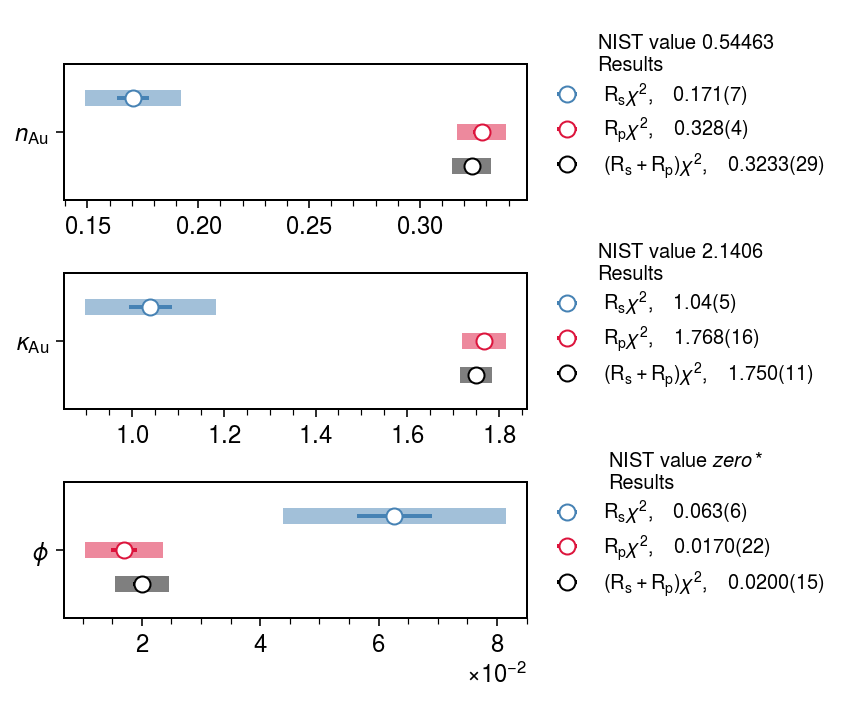

In [17]:

def p_plot(RsM: Minuit, RpM: Minuit, RRM: Minuit, names: dict, th_values: dict, plot_fixed=True):
    
    s_color = 'steelblue'
    p_color = 'crimson'
    
    if plot_fixed:
        N = np.count_nonzero(~RRM.fixed)
    else:
        N = RRM.npar
    
    fig, axs = plt.subplots(N, 1, figsize=(4.0, 1.5 * N))
    fig.tight_layout()
    
    RsMData = np.array([RsM.values, RsM.errors]).T
    RpMData = np.array([RpM.values, RpM.errors]).T
    RRMData = np.array([RRM.values, RRM.errors]).T
    
    j=0
    
    for i, (Rs, Rp, RR, name_key) in enumerate(zip(RsMData, RpMData, RRMData, names.keys())):
        if plot_fixed:
            if RRM.fixed[i]:
                continue
            else:
                pass
        else:
            pass
        
        axs[j].errorbar(y= 0.1, x=Rs[0], xerr=Rs[1], color=s_color, ecolor=s_color, fmt='o', mfc='w', 
                        label=f'$\mathrm{{R_s}}\chi^2, \quad{ufloat(Rs[0], Rs[1]):uSL}$')
        axs[j].errorbar(y= 0.1, x=Rs[0], xerr=3 * Rs[1], color=s_color, fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba(s_color, 0.5), zorder=1)
        
        axs[j].errorbar(y= 0.,  x=Rp[0], xerr=Rp[1], color=p_color, ecolor=p_color, fmt='o', mfc='w', 
                        label=f'$\mathrm{{R_p}}\chi^2, \quad{ufloat(Rp[0], Rp[1]):uSL}$')
        axs[j].errorbar(y= 0.,  x=Rp[0], xerr=3 * Rp[1], color=p_color, fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba(p_color, 0.5), zorder=1)
        
        axs[j].errorbar(y=-0.1, x=RR[0], xerr=RR[1], color='k', ecolor='k', fmt='o', mfc='w', 
                        label=f'$\mathrm{{(R_s+R_p)}}\chi^2, \quad{ufloat(RR[0], RR[1]):uSL}$')
        axs[j].errorbar(y=-0.1, x=RR[0], xerr=3 * RR[1], color='k', fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba('k', 0.5), zorder=1)
        
        axs[j].set_ylim(-0.2, 0.2)
        axs[j].set_yticks(ticks=[0.], labels=[f'${names[name_key]}$'])
        # axs[j].axvline(th_values[name_key], color='k', ls=':', lw='1')
        axs[j].legend(loc=(1.,0), title=f'NIST value ${th_values[name_key]}$\nResults')
        
        j += 1

p_plot(RsC2MM, RpC2MM, CommRRC2MM, names, theorehical_values)
plt.savefig('../figures/Au_results_all.pdf', bbox_inches='tight')

In [18]:
from scipy import stats


for name, M in zip(['(R_\mathrm{p} + R_\mathrm{s})\chi^2_\mathrm{Au}','(R_\mathrm{p})\chi^2', '(R_\mathrm{s})\chi^2'],[RsC2MM, RpC2MM, CommRRC2MM]):
    print(f'{name}, p-value: {1 - stats.chi2.cdf(M.fmin.fval, M.ndof)}, χ2/df = {M.fval, M.ndof}')

(R_\mathrm{p} + R_\mathrm{s})\chi^2_\mathrm{Au}, p-value: 0.0, χ2/df = (1577.8398497903383, 14.0)
(R_\mathrm{p})\chi^2, p-value: 0.0, χ2/df = (454.5086909883041, 13.0)
(R_\mathrm{s})\chi^2, p-value: 0.0, χ2/df = (2116.2693419669404, 30.0)


## Plot appendici

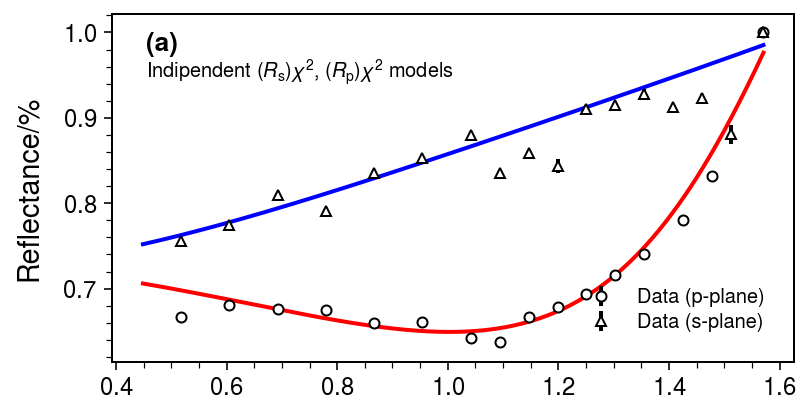

In [19]:

plt.figure(figsize=(6,3))

p_Au.plot(marker='o')
s_Au.plot(marker='^')
plt.xlabel('')

CLs_plot(RpC2MM, modelRp, angles, parameters, color='r')
CLs_plot(RsC2MM, modelRs, angles, parameters, color='b')
hep.label.exp_text('(a)', 'Indipendent $(R_\mathrm{s})\chi^2$, $(R_\mathrm{p})\chi^2$ models', loc=2)
plt.legend(loc=4)
plt.savefig('../figures/Au_Ind_RsChi2_RpChi2.pdf', bbox_inches='tight')

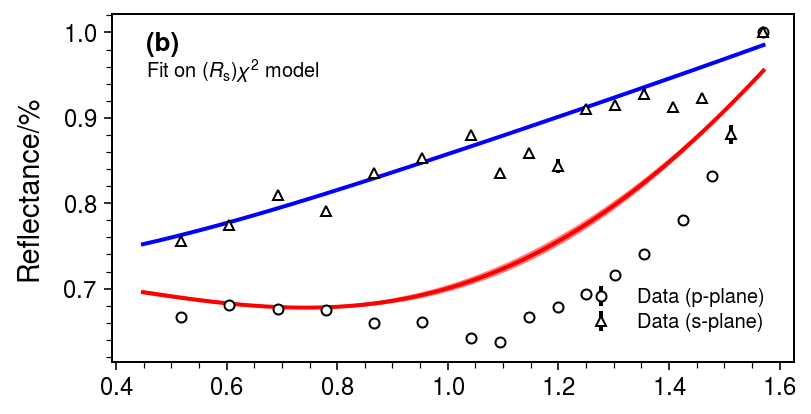

In [20]:
plt.figure(figsize=(6,3))

p_Au.plot(marker='o')
s_Au.plot(marker='^')
plt.xlabel('')

CLs_plot(RsC2MM, modelRp, angles, parameters, color='r')
CLs_plot(RsC2MM, modelRs, angles, parameters, color='b')
hep.label.exp_text('(b)', 'Fit on $(R_\mathrm{s})\chi^2$ model', loc=2)
plt.legend(loc=4)

plt.savefig('../figures/Au_Both_RsChi2.pdf', bbox_inches='tight')

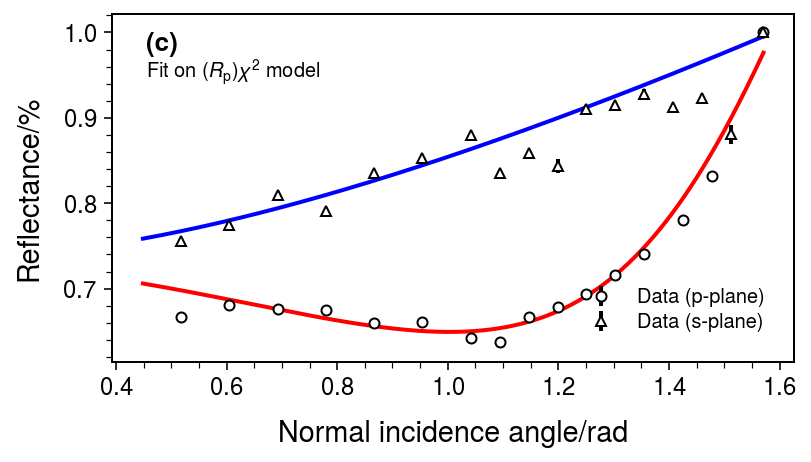

In [21]:

plt.figure(figsize=(6,3))

p_Au.plot(marker='o')
s_Au.plot(marker='^')

CLs_plot(RpC2MM, modelRp, angles, parameters, color='r')
CLs_plot(RpC2MM, modelRs, angles, parameters, color='b')
hep.label.exp_text('(c)', 'Fit on $(R_\mathrm{p})\chi^2$ model', loc=2)
plt.legend(loc=4)
plt.savefig('../figures/Au_Both_RpChi2.pdf', bbox_inches='tight')

In [22]:
import scipy.optimize

def get_minimum(M: Minuit):

    bounds = [0.4, 1.4]
    
    def array_j(j, n): 
        a = np.zeros(n)
        a[j] += 1
        return a
    
    p0, p1, p2, p3, p4 = M.values
    p0_std, p1_std, p2_std, p3_std, p4_std = M.errors
    
    values = [p0, p1, p2, p3, p4]
    errors = [p0_std, p1_std, p2_std, p3_std, p4_std]
    
    maximum = scipy.optimize.minimize_scalar(lambda x: modelRp(x, M.values), bounds=bounds, method='bounded').x
    error_squared_pos = 0
    error_squared_neg = 0
    
    for j in range(3):
        corrected_values_positive = [values[i] + (array_j(j + 2, 5)*errors)[i] for i in range(5)]
        corrected_values_negative = [values[i] - (array_j(j + 2, 5)*errors)[i] for i in range(5)]
        error_squared_pos += np.abs(
            scipy.optimize.minimize_scalar(lambda x: modelRp(x, corrected_values_positive), bounds=bounds, method='bounded').x - maximum
        )**2
        error_squared_neg += np.abs(
            scipy.optimize.minimize_scalar(lambda x: modelRp(x, corrected_values_negative), bounds=bounds, method='bounded').x - maximum
        )**2
    
    return maximum, error_squared_neg, error_squared_pos
    
    

In [23]:

maxx, neg, pos = get_minimum(CommRRC2MM)

print(f'θ_B = {ufloat(maxx, pos):.uS}')

θ_B = 1.000055(14)


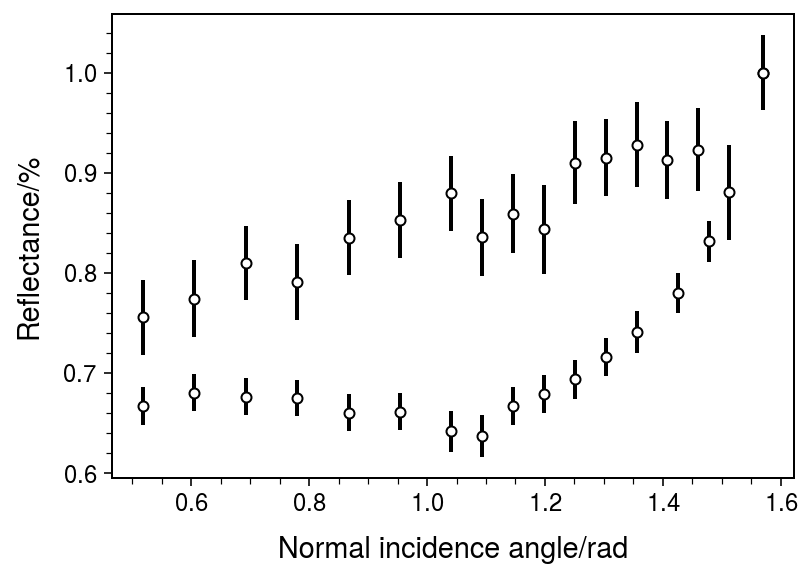

In [24]:
s_Au.reflectance_std += error_RS_scale
p_Au.reflectance_std += error_RP_scale

s_Au.plot()
p_Au.plot()

In [25]:


CommRRChi2_rescaled = (
    LeastSquares(s_Au.angles, s_Au.reflectance, s_Au.reflectance_std, model=modelRs) + 
    LeastSquares(p_Au.angles, p_Au.reflectance, p_Au.reflectance_std, model=modelRp)
)

CommRRC2MM_rescaled = Minuit(CommRRChi2_rescaled, parameters)

# Fixing Air values
CommRRC2MM_rescaled.fixed[0] = True
CommRRC2MM_rescaled.fixed[1] = True

CommRRC2MM_rescaled.limits[2] = (0,2)
CommRRC2MM_rescaled.limits[3] = (0,3)

CommRRC2MM_rescaled.migrad()
CommRRC2MM_rescaled.hesse()
CommRRC2MM_rescaled.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.27 (chi2/ndof = 0.6)    │              Nfcn = 123              │
│ EDM = 1.72e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │   0.330   │   0.026   │            │            │    0    │    2    │       │
│ 3 │ x3   │   1.76    │   0.11    │            │            │    0    │    3    │       │
│ 4 │ x4   │   0.023   │   0.013   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0  0.000651   0.00277 -0.000241 │
│ x3 │         0         0   0.00277    0.0127    -0.001 │
│ x4 │         0         0 -0.000241    -0.001  0.000166 │
└────┴───────────────────────────────────────────────────┘

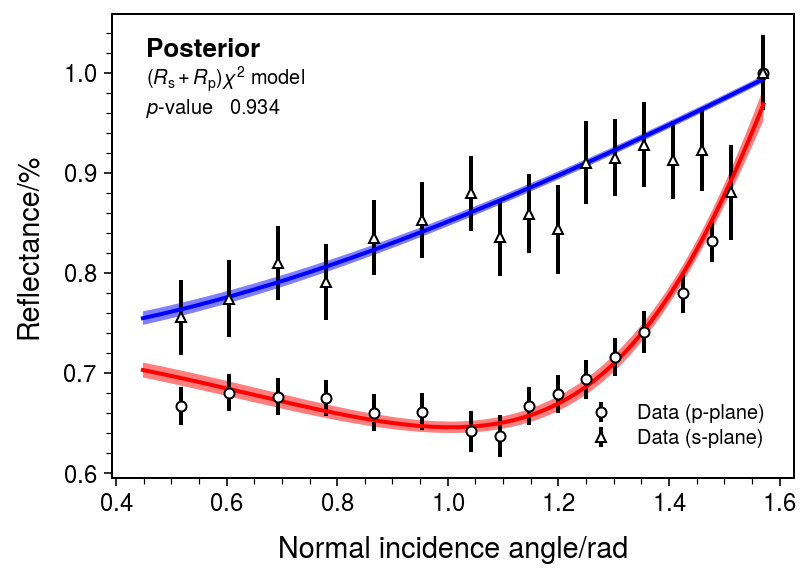

In [32]:
import ROOT

p_Au.plot(marker='o')
s_Au.plot(marker='^')

CLs_plot(CommRRC2MM_rescaled, modelRp, angles, parameters, color='r')
CLs_plot(CommRRC2MM_rescaled, modelRs, angles, parameters, color='b')

p=1 - stats.chi2.cdf(CommRRC2MM_rescaled.fmin.fval, CommRRC2MM_rescaled.ndof)

hep.label.exp_text('Posterior', f'$(R_\mathrm{{s}} + R_\mathrm{{p}})\chi^2$ model\n$p$-value$\quad{p:.3}$', loc=2)
plt.legend(loc=4)
plt.savefig('../figures/Au_rescaled_fit.pdf', bbox_inches='tight')

In [27]:

maxx, neg, pos = get_minimum(CommRRC2MM_rescaled)


print(f'θ_B = {ufloat(maxx, pos):.uS} rad, {ufloat(np.rad2deg(maxx), np.rad2deg(pos)):.uS} deg')

θ_B = 1.0052(12) rad, 57.60(7) deg


In [28]:
for v, e, n in zip(CommRRC2MM_rescaled.values, CommRRC2MM_rescaled.errors, names.keys()):
    print(f'{n}: {ufloat(v,e):.uSL}')

nAir: 1.000(10)
kAir: 0.00(10)
nAu: 0.330(26)
kAu: 1.76(11)
phase: 0.023(13)


In [29]:
np.rad2deg(np.arctan(n_Air/n_Au))

61.43265721738403

In [38]:
nAu, nAu_std = 0.330, 0.026
kAu, kAu_std = 1.76, 0.11


In [42]:
np.abs(n_Au-nAu)/nAu_std

8.254999999999997

In [43]:
np.abs(k_Au-kAu)/kAu_std

3.4600000000000004

In [45]:
n_Au, k_Au

(0.54463, 2.1406)